IMPORTS


In [ ]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as T
from PIL import Image
import scipy.ndimage as ndimage
from tqdm import tqdm
import random
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


if device.type == 'cuda':
    print(f'Device name: {torch.cuda.get_device_name(0)}')
    print(f'Number of GPUs available: {torch.cuda.device_count()}')
    print('Memory Usage:')
    print(f'Allocated: {round(torch.cuda.memory_allocated(0) / 1024**3, 1)} GB')
    print(f'Cached: {round(torch.cuda.memory_reserved(0) / 1024**3, 1)} GB')

Using device: cuda
Device name: Tesla T4
Number of GPUs available: 1
Memory Usage:
Allocated: 0.0 GB
Cached: 0.0 GB


In [ ]:
import kagglehub
briscdataset_brisc2025_path = kagglehub.dataset_download('briscdataset/brisc2025')
print('Data source import complete.')

Using Colab cache for faster access to the 'brisc2025' dataset.
Data source import complete.


In [ ]:
# DATA PREPARATION

In [ ]:
# base_seg_path = r"C:\Users\User\.cache\kagglehub\datasets\briscdataset\brisc2025\versions\5\brisc2025\segmentation_task"
# base_cls_path = r"C:\Users\User\.cache\kagglehub\datasets\briscdataset\brisc2025\versions\5\brisc2025\classification_task"

# Actual dataset folder inside version
dataset_root = os.path.join(briscdataset_brisc2025_path, "brisc2025")

# Segmentation task
base_seg_path = os.path.join(dataset_root, "segmentation_task")

seg_train_img  = os.path.join(base_seg_path, "train", "images")
seg_train_mask = os.path.join(base_seg_path, "train", "masks")
seg_test_img   = os.path.join(base_seg_path, "test", "images")
seg_test_mask  = os.path.join(base_seg_path, "test", "masks")

# Classification task
base_cls_path = os.path.join(dataset_root, "classification_task")

cls_train_dir = os.path.join(base_cls_path, "train")
cls_test_dir  = os.path.join(base_cls_path, "test")


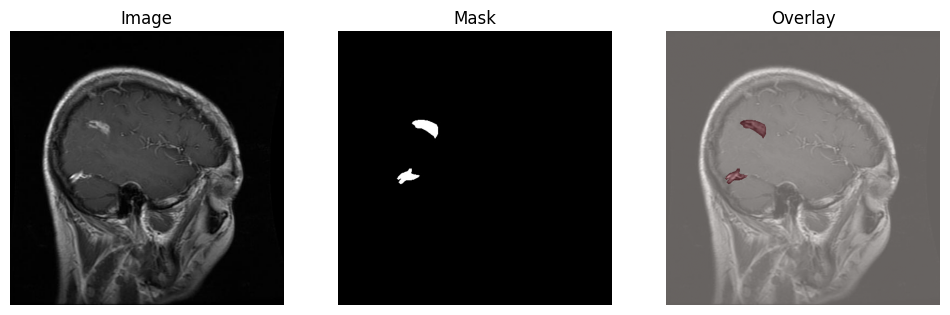

In [ ]:
img_files = [f for f in os.listdir(seg_train_img) if f.endswith('.jpg')]
rand_file = random.choice(img_files)
img_path = os.path.join(seg_train_img, rand_file)
mask_path = os.path.join(seg_train_mask, rand_file.replace(".jpg", ".png"))

img = Image.open(img_path).convert("RGB")
mask = Image.open(mask_path).convert("L")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(mask, cmap="Reds", alpha=0.4)
plt.title("Overlay")
plt.axis("off")

plt.show()

In [ ]:
tumor_names = {0: "Glioma", 1: "Meningioma", 2: "Pituitary", 3: "No Tumor"}

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


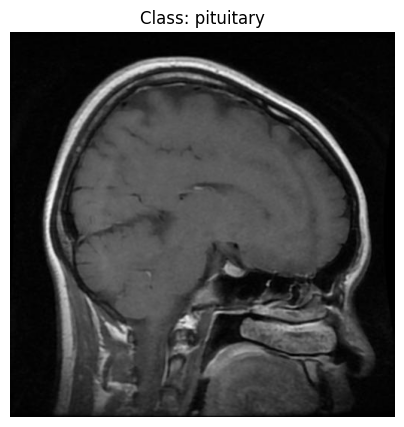

In [ ]:
cls_train_root = os.path.join(base_cls_path, "train")
cls_test_root  = os.path.join(base_cls_path, "test")

# List class folders
classes = sorted(os.listdir(cls_train_root))
print("Classes:", classes)

# Pick random class
rand_class = random.choice(classes)
class_dir = os.path.join(cls_train_root, rand_class)

# Pick random image from that class
rand_file = random.choice(os.listdir(class_dir))
img_path = os.path.join(class_dir, rand_file)

# Load image
img = Image.open(img_path).convert("RGB")

# Show
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(f"Class: {rand_class}")
plt.axis("off")
plt.show()

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, size=(256, 256), transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.transform = transform or T.Compose([
            T.Grayscale(),
            T.Resize(size),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png"))
        image = self.transform(Image.open(img_path))
        mask = self.transform(Image.open(mask_path))
        return image, mask

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, root_dir, size=(256, 256), transform=None):
        self.root_dir = root_dir
        self.transform = transform or T.Compose([
            T.Grayscale(),
            T.Resize(size),
            T.ToTensor(),
        ])
        self.images = []
        self.labels = []
        for label, class_dir in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_dir)
            for img_file in os.listdir(class_path):
                if img_file.endswith('.jpg'):
                    self.images.append(os.path.join(class_path, img_file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = self.transform(Image.open(img_path))
        label = self.labels[idx]
        return image, label

In [ ]:
class BatchLoader:
    def __init__(self, dataset, batch_size=16, shuffle=True, device='cpu', task='segmentation'):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.device = device
        self.task = task
        self.indices = np.arange(len(dataset))
        self.len = int(np.ceil(len(dataset) / batch_size))
        if shuffle:
            np.random.shuffle(self.indices)
        self.iter = 0

    def __iter__(self):
        self.iter = 0
        if self.shuffle:
            np.random.shuffle(self.indices)
        return self

    def __next__(self):
        if self.iter >= self.len:
            raise StopIteration

        start = self.iter * self.batch_size
        idx = self.indices[start:start + self.batch_size]
        self.iter += 1

        batch = [self.dataset[i] for i in idx]
        if self.task == 'classification':
            batch_x = torch.stack([x for x, _ in batch])
            batch_y = torch.tensor([y for _, y in batch], dtype=torch.long)
            if batch_y.max() >= 4 or batch_y.min() < 0:
                raise ValueError(f"Invalid labels in batch: {batch_y}")
            assert batch_x.shape == (len(idx), 1, 256, 256), f"Unexpected input shape: {batch_x.shape}"
            assert batch_y.shape == (len(idx),), f"Unexpected label shape: {batch_y.shape}"
            return batch_x.to(self.device), batch_y.to(self.device)
        elif self.task == 'segmentation':
            batch_x = torch.stack([x for x, _ in batch])
            batch_y = torch.stack([y for _, y in batch])
            assert batch_x.shape == (len(idx), 1, 256, 256), f"Unexpected input shape: {batch_x.shape}"
            assert batch_y.shape == (len(idx), 1, 256, 256), f"Unexpected mask shape: {batch_y.shape}"
            return batch_x.to(self.device), batch_y.to(self.device)
        elif self.task == 'both':
            batch_x = torch.stack([x for x, _, _ in batch])
            batch_y_label = torch.tensor([y_label for _, y_label, _ in batch], dtype=torch.long)
            batch_y_mask = torch.stack([y_mask for _, _, y_mask in batch])
            if batch_y_label.max() >= 4 or batch_y_label.min() < 0:
                raise ValueError(f"Invalid labels in batch: {batch_y_label}")
            assert batch_x.shape == (len(idx), 1, 256, 256), f"Unexpected input shape: {batch_x.shape}"
            assert batch_y_label.shape == (len(idx),), f"Unexpected label shape: {batch_y_label.shape}"
            assert batch_y_mask.shape == (len(idx), 1, 256, 256), f"Unexpected mask shape: {batch_y_mask.shape}"
            return batch_x.to(self.device), batch_y_label.to(self.device), batch_y_mask.to(self.device)

    def next(self, task=None):
        return self.__next__()

    def __len__(self):
        return self.len

CREATING MODELS:

U-NET


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        skip = self.conv(x)
        return self.pool(skip), skip

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        return self.conv(x)


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super().__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = Bottleneck(512, 1024)
        self.decoder1 = Decoder(1024, 512)
        self.decoder2 = Decoder(512, 256)
        self.decoder3 = Decoder(256, 128)
        self.decoder4 = Decoder(128, 64)
        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        skip1 = self.encoder1(x)
        x = self.pool1(skip1)
        skip2 = self.encoder2(x)
        x = self.pool2(skip2)
        skip3 = self.encoder3(x)
        x = self.pool3(skip3)
        skip4 = self.encoder4(x)
        x = self.pool4(skip4)
        b = self.bottleneck(x)
        d1 = self.decoder1(b, skip4)
        d2 = self.decoder2(d1, skip3)
        d3 = self.decoder3(d2, skip2)
        d4 = self.decoder4(d3, skip1)
        out = self.output_conv(d4)
        return out

ATTACHING CLASSIFER HEAD

In [ ]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = Bottleneck(512, 1024)

    def forward(self, x):
        x = self.encoder1(x)
        x = self.pool1(x)
        x = self.encoder2(x)
        x = self.pool2(x)
        x = self.encoder3(x)
        x = self.pool3(x)
        x = self.encoder4(x)
        x = self.pool4(x)
        b = self.bottleneck(x)
        return b



In [ ]:
class Classifier(nn.Module):
    def __init__(self, in_channels=1, num_classes=4):
        super().__init__()
        self.encoder = UNetEncoder(in_channels)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        b = self.encoder(x)
        p = self.pool(b).squeeze(-1).squeeze(-1)
        out = self.fc(p)
        return out

ATTENTION U-NET

In [ ]:
class AttentionGate(nn.Module):
    def __init__(self, g_channels, x_channels, inter_channels):
        super().__init__()
        self.Wg = nn.Conv2d(g_channels, inter_channels, kernel_size=1, stride=1)
        self.Wx = nn.Conv2d(x_channels, inter_channels, kernel_size=1, stride=1)
        self.psi = nn.Conv2d(inter_channels, 1, kernel_size=1, stride=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    def forward(self, g, x):
        if x.size()[2:] != g.size()[2:]:
            x_down = F.interpolate(x, size=g.size()[2:], mode='bilinear', align_corners=True)
        else:
            x_down = x
        wg = self.Wg(g)
        wx = self.Wx(x_down)
        att = F.relu(wg + wx)
        att = self.psi(att)
        att = torch.sigmoid(att)
        att = self.upsample(att) if att.size()[2:] != x.size()[2:] else att
        return att * x


In [ ]:
class AttentionDecoder(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.att = AttentionGate(out_channels, skip_channels, skip_channels // 2)
        self.conv = DoubleConv(out_channels + skip_channels, out_channels)
    def forward(self, x, skip):
        x = self.upconv(x)
        att_skip = self.att(x, skip)
        x = torch.cat([x, att_skip], dim=1)
        return self.conv(x)


In [ ]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super().__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = Bottleneck(512, 1024)
        self.decoder1 = AttentionDecoder(1024, 512, 512)
        self.decoder2 = AttentionDecoder(512, 256, 256)
        self.decoder3 = AttentionDecoder(256, 128, 128)
        self.decoder4 = AttentionDecoder(128, 64, 64)
        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)
    def forward(self, x):
        skip1 = self.encoder1(x)
        x = self.pool1(skip1)
        skip2 = self.encoder2(x)
        x = self.pool2(skip2)
        skip3 = self.encoder3(x)
        x = self.pool3(skip3)
        skip4 = self.encoder4(x)
        x = self.pool4(skip4)
        b = self.bottleneck(x)
        d1 = self.decoder1(b, skip4)
        d2 = self.decoder2(d1, skip3)
        d3 = self.decoder3(d2, skip2)
        d4 = self.decoder4(d3, skip1)
        out = self.output_conv(d4)
        return out

DEFINING LOSS

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        sum_preds_targets = preds.sum() + targets.sum()
        if sum_preds_targets == 0:
            return torch.tensor(1.0, device=preds.device)
        dice_loss = 1 - (2. * intersection + self.epsilon) / (sum_preds_targets + self.epsilon)
        return dice_loss

In [ ]:
def calculate_iou(y_pred, y_true, threshold=0.5, eps=1e-6):
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()
    y_pred = y_pred.view(y_pred.shape[0], -1)
    y_true = y_true.view(y_true.shape[0], -1)
    intersection = (y_pred * y_true).sum(dim=1)
    union = y_pred.sum(dim=1) + y_true.sum(dim=1) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

img_size = (256, 256)

seg_train_dataset = SegmentationDataset(seg_train_img, seg_train_mask, size=img_size)
seg_train_loader = BatchLoader(seg_train_dataset, batch_size=16, shuffle=True, device=device, task='segmentation')
seg_test_dataset = SegmentationDataset(seg_test_img, seg_test_mask, size=img_size)
seg_test_loader = BatchLoader(seg_test_dataset, batch_size=16, shuffle=False, device=device, task='segmentation')

cls_train_dataset = ClassificationDataset(cls_train_dir, size=img_size)
cls_train_loader = BatchLoader(cls_train_dataset, batch_size=16, shuffle=True, device=device, task='classification')
cls_test_dataset = ClassificationDataset(cls_test_dir, size=img_size)
cls_test_loader = BatchLoader(cls_test_dataset, batch_size=16, shuffle=False, device=device, task='classification')


Using device: cuda


MODEL TRAINING


U-NET TRAINING


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_unet = UNet(in_channels=1, num_classes=1).to(device)

for x, y in tqdm(seg_train_loader, desc="Training"):
    x = x.to(device)
    y = y.to(device)


Using device: cuda


Training: 100%|██████████| 246/246 [00:48<00:00,  5.11it/s]


In [ ]:

# Train U-Net for segmentation
model_unet = UNet(in_channels=1, num_classes=1).to(device)
optim_unet = torch.optim.AdamW(model_unet.parameters(), lr=0.0001)
dice_loss = DiceLoss()
bce_loss = nn.BCEWithLogitsLoss()

num_epochs = 25

for epoch in range(num_epochs):
    print(f"Epoch - {epoch+1}")
    model_unet.train()
    train_bce = 0.0
    train_dice = 0.0
    train_iou = 0.0

    for x, y in tqdm(seg_train_loader, desc="Training"):
        if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
            print("NaN/Inf detected in input or mask")
            continue
        y_pred = model_unet(x)
        if torch.isnan(y_pred).any() or torch.isinf(y_pred).any():
            print("NaN/Inf detected in predictions")
            continue
        bce = bce_loss(y_pred, y)
        dice = dice_loss(y_pred, y)
        iou = calculate_iou(y_pred, y)
        loss = 0.2 * bce + 0.8 * dice
        optim_unet.zero_grad()
        loss.backward()
        optim_unet.step()
        train_bce += bce.item()
        train_dice += dice.item()
        train_iou += iou.item()

    avg_train_bce = train_bce / len(seg_train_loader)
    avg_train_dice = train_dice / len(seg_train_loader)
    avg_train_iou = train_iou / len(seg_train_loader)

    model_unet.eval()
    test_bce = 0.0
    test_dice = 0.0
    test_iou = 0.0
    with torch.no_grad():
        for x, y in seg_test_loader:
            if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
                print("NaN/Inf detected in test input or mask")
                continue
            y_pred = model_unet(x)
            test_bce += bce_loss(y_pred, y).item()
            test_dice += dice_loss(y_pred, y).item()
            test_iou += calculate_iou(y_pred, y).item()

    avg_test_bce = test_bce / len(seg_test_loader)
    avg_test_dice = test_dice / len(seg_test_loader)
    avg_test_iou = test_iou / len(seg_test_loader)

    print(f"Train BCE loss - {avg_train_bce:.6f} | Train Dice loss - {avg_train_dice:.6f} | Train IoU - {avg_train_iou:.6f}")
    print(f"Test BCE loss - {avg_test_bce:.6f} | Test Dice loss - {avg_test_dice:.6f} | Test IoU - {avg_test_iou:.6f}")
    print()

torch.save(model_unet.state_dict(), 'model_unet.pth')

Epoch - 1


Training: 100%|██████████| 246/246 [03:31<00:00,  1.16it/s]


Train BCE loss - 0.286360 | Train Dice loss - 0.894426 | Train IoU - 0.340967
Test BCE loss - 0.303435 | Test Dice loss - 0.860055 | Test IoU - 0.257746

Epoch - 2


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.146866 | Train Dice loss - 0.803766 | Train IoU - 0.467712
Test BCE loss - 0.122461 | Test Dice loss - 0.748725 | Test IoU - 0.465065

Epoch - 3


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.077462 | Train Dice loss - 0.658068 | Train IoU - 0.567509
Test BCE loss - 0.064210 | Test Dice loss - 0.594265 | Test IoU - 0.580793

Epoch - 4


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.045198 | Train Dice loss - 0.475818 | Train IoU - 0.632332
Test BCE loss - 0.038205 | Test Dice loss - 0.445710 | Test IoU - 0.628652

Epoch - 5


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.034996 | Train Dice loss - 0.344909 | Train IoU - 0.660615
Test BCE loss - 0.052463 | Test Dice loss - 0.345241 | Test IoU - 0.612798

Epoch - 6


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.030933 | Train Dice loss - 0.267097 | Train IoU - 0.682511
Test BCE loss - 0.032301 | Test Dice loss - 0.259126 | Test IoU - 0.688157

Epoch - 7


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.028506 | Train Dice loss - 0.220067 | Train IoU - 0.702293
Test BCE loss - 0.029709 | Test Dice loss - 0.232469 | Test IoU - 0.691184

Epoch - 8


Training: 100%|██████████| 246/246 [03:31<00:00,  1.16it/s]


Train BCE loss - 0.026619 | Train Dice loss - 0.191001 | Train IoU - 0.716815
Test BCE loss - 0.042600 | Test Dice loss - 0.245613 | Test IoU - 0.664517

Epoch - 9


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.025883 | Train Dice loss - 0.172920 | Train IoU - 0.728066
Test BCE loss - 0.031768 | Test Dice loss - 0.200309 | Test IoU - 0.715315

Epoch - 10


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.024366 | Train Dice loss - 0.156634 | Train IoU - 0.740402
Test BCE loss - 0.029655 | Test Dice loss - 0.182466 | Test IoU - 0.724099

Epoch - 11


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.023584 | Train Dice loss - 0.145397 | Train IoU - 0.749746
Test BCE loss - 0.030239 | Test Dice loss - 0.175843 | Test IoU - 0.713703

Epoch - 12


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.023209 | Train Dice loss - 0.138263 | Train IoU - 0.753583
Test BCE loss - 0.032416 | Test Dice loss - 0.170170 | Test IoU - 0.711066

Epoch - 13


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.023379 | Train Dice loss - 0.137325 | Train IoU - 0.753923
Test BCE loss - 0.034574 | Test Dice loss - 0.175630 | Test IoU - 0.715117

Epoch - 14


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.022399 | Train Dice loss - 0.128156 | Train IoU - 0.757643
Test BCE loss - 0.031811 | Test Dice loss - 0.172125 | Test IoU - 0.722104

Epoch - 15


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.023816 | Train Dice loss - 0.131711 | Train IoU - 0.756528
Test BCE loss - 0.033622 | Test Dice loss - 0.173828 | Test IoU - 0.707220

Epoch - 16


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.022352 | Train Dice loss - 0.123159 | Train IoU - 0.765541
Test BCE loss - 0.030827 | Test Dice loss - 0.151780 | Test IoU - 0.740935

Epoch - 17


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.020830 | Train Dice loss - 0.114312 | Train IoU - 0.774547
Test BCE loss - 0.030755 | Test Dice loss - 0.152080 | Test IoU - 0.741343

Epoch - 18


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.021275 | Train Dice loss - 0.114681 | Train IoU - 0.778880
Test BCE loss - 0.034072 | Test Dice loss - 0.165969 | Test IoU - 0.720361

Epoch - 19


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.020639 | Train Dice loss - 0.110844 | Train IoU - 0.782405
Test BCE loss - 0.033918 | Test Dice loss - 0.155648 | Test IoU - 0.728059

Epoch - 20


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.019973 | Train Dice loss - 0.105912 | Train IoU - 0.787846
Test BCE loss - 0.030609 | Test Dice loss - 0.148112 | Test IoU - 0.744382

Epoch - 21


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.019252 | Train Dice loss - 0.101411 | Train IoU - 0.791803
Test BCE loss - 0.031086 | Test Dice loss - 0.150587 | Test IoU - 0.738381

Epoch - 22


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.019448 | Train Dice loss - 0.102110 | Train IoU - 0.792711
Test BCE loss - 0.034340 | Test Dice loss - 0.162372 | Test IoU - 0.732597

Epoch - 23


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.019360 | Train Dice loss - 0.102747 | Train IoU - 0.794029
Test BCE loss - 0.031079 | Test Dice loss - 0.145357 | Test IoU - 0.747801

Epoch - 24


Training: 100%|██████████| 246/246 [03:32<00:00,  1.16it/s]


Train BCE loss - 0.017846 | Train Dice loss - 0.092674 | Train IoU - 0.805493
Test BCE loss - 0.031543 | Test Dice loss - 0.151848 | Test IoU - 0.744539

Epoch - 25


Training: 100%|██████████| 246/246 [03:31<00:00,  1.16it/s]


Train BCE loss - 0.017827 | Train Dice loss - 0.092950 | Train IoU - 0.804076
Test BCE loss - 0.030134 | Test Dice loss - 0.141533 | Test IoU - 0.752486



MODEL TRAIN: CLASSIFIER

In [ ]:
model_cls = Classifier(in_channels=1, num_classes=4).to(device)  # Updated to 4 classes
optim_cls = torch.optim.AdamW(model_cls.parameters(), lr=0.0001)
loss_cls = nn.CrossEntropyLoss()
num_epochs=25
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model_cls.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in tqdm(cls_train_loader, desc="Training"):
        if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
            print("NaN/Inf detected in input or label")
            continue
        y_pred = model_cls(x)
        loss = loss_cls(y_pred, y)
        optim_cls.zero_grad()
        loss.backward()
        optim_cls.step()
        running_loss += loss.item()
        correct += (y_pred.argmax(1) == y).sum().item()
        total += y.size(0)

    avg_loss = running_loss / len(cls_train_loader)
    train_acc = correct / total
    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    model_cls.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for x, y in cls_test_loader:
            if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
                print("NaN/Inf detected in test input or label")
                continue
            y_pred = model_cls(x)
            test_loss += loss_cls(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).sum().item()
            total += y.size(0)

    avg_test_loss = test_loss / len(cls_test_loader)
    test_acc = correct / total
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


torch.save(model_cls.state_dict(), 'model_cls.pth')

Epoch 1/25


Training: 100%|██████████| 313/313 [02:08<00:00,  2.44it/s]


Train Loss: 0.6203, Train Accuracy: 0.7672
Test Loss: 1.0313, Test Accuracy: 0.5700
Epoch 2/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.04it/s]


Train Loss: 0.4270, Train Accuracy: 0.8448
Test Loss: 0.7077, Test Accuracy: 0.7140
Epoch 3/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.3398, Train Accuracy: 0.8774
Test Loss: 0.3510, Test Accuracy: 0.8640
Epoch 4/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.2752, Train Accuracy: 0.9006
Test Loss: 0.9872, Test Accuracy: 0.7220
Epoch 5/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.2345, Train Accuracy: 0.9152
Test Loss: 0.6028, Test Accuracy: 0.7980
Epoch 6/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.04it/s]


Train Loss: 0.2000, Train Accuracy: 0.9302
Test Loss: 0.5819, Test Accuracy: 0.7850
Epoch 7/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.1783, Train Accuracy: 0.9368
Test Loss: 0.9327, Test Accuracy: 0.7190
Epoch 8/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.1434, Train Accuracy: 0.9508
Test Loss: 0.7273, Test Accuracy: 0.7230
Epoch 9/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.1322, Train Accuracy: 0.9534
Test Loss: 0.2673, Test Accuracy: 0.9070
Epoch 10/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.1198, Train Accuracy: 0.9608
Test Loss: 0.2040, Test Accuracy: 0.9270
Epoch 11/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.02it/s]


Train Loss: 0.0922, Train Accuracy: 0.9710
Test Loss: 0.5270, Test Accuracy: 0.8600
Epoch 12/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0925, Train Accuracy: 0.9696
Test Loss: 0.2198, Test Accuracy: 0.9310
Epoch 13/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0917, Train Accuracy: 0.9684
Test Loss: 0.9306, Test Accuracy: 0.7790
Epoch 14/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0760, Train Accuracy: 0.9756
Test Loss: 0.2358, Test Accuracy: 0.9360
Epoch 15/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.02it/s]


Train Loss: 0.0646, Train Accuracy: 0.9818
Test Loss: 0.2473, Test Accuracy: 0.9050
Epoch 16/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.02it/s]


Train Loss: 0.0481, Train Accuracy: 0.9858
Test Loss: 0.1284, Test Accuracy: 0.9610
Epoch 17/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0608, Train Accuracy: 0.9818
Test Loss: 0.0982, Test Accuracy: 0.9680
Epoch 18/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0615, Train Accuracy: 0.9810
Test Loss: 0.5040, Test Accuracy: 0.8310
Epoch 19/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0338, Train Accuracy: 0.9900
Test Loss: 0.0998, Test Accuracy: 0.9700
Epoch 20/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0446, Train Accuracy: 0.9844
Test Loss: 0.2333, Test Accuracy: 0.9230
Epoch 21/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0426, Train Accuracy: 0.9840
Test Loss: 0.0849, Test Accuracy: 0.9760
Epoch 22/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0493, Train Accuracy: 0.9844
Test Loss: 0.0979, Test Accuracy: 0.9700
Epoch 23/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0393, Train Accuracy: 0.9878
Test Loss: 0.1471, Test Accuracy: 0.9600
Epoch 24/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0556, Train Accuracy: 0.9806
Test Loss: 0.3178, Test Accuracy: 0.9000
Epoch 25/25


Training: 100%|██████████| 313/313 [01:43<00:00,  3.03it/s]


Train Loss: 0.0363, Train Accuracy: 0.9870
Test Loss: 0.1006, Test Accuracy: 0.9730


TRAINING ON ATTENTION UNET

In [ ]:
model_att_unet = AttentionUNet(in_channels=1, num_classes=1).to(device)
optim_att = torch.optim.AdamW(model_att_unet.parameters(), lr=0.0001)
num_epochs=25
for epoch in range(num_epochs):
    print(f"Epoch - {epoch+1}")
    model_att_unet.train()
    train_bce = 0.0
    train_dice = 0.0
    train_iou = 0.0

    for x, y in tqdm(seg_train_loader, desc="Training"):
        if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
            print("NaN/Inf detected in input or mask")
            continue
        y_pred = model_att_unet(x)
        if torch.isnan(y_pred).any() or torch.isinf(y_pred).any():
            print("NaN/Inf detected in predictions")
            continue
        bce = bce_loss(y_pred, y)
        dice = dice_loss(y_pred, y)
        iou = calculate_iou(y_pred, y)
        loss = 0.2 * bce + 0.8 * dice
        optim_att.zero_grad()
        loss.backward()
        optim_att.step()
        train_bce += bce.item()
        train_dice += dice.item()
        train_iou += iou.item()

    avg_train_bce = train_bce / len(seg_train_loader)
    avg_train_dice = train_dice / len(seg_train_loader)
    avg_train_iou = train_iou / len(seg_train_loader)

    model_att_unet.eval()
    test_bce = 0.0
    test_dice = 0.0
    test_iou = 0.0
    with torch.no_grad():
        for x, y in seg_test_loader:
            if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
                print("NaN/Inf detected in test input or mask")
                continue
            y_pred = model_att_unet(x)
            test_bce += bce_loss(y_pred, y).item()
            test_dice += dice_loss(y_pred, y).item()
            test_iou += calculate_iou(y_pred, y).item()

    avg_test_bce = test_bce / len(seg_test_loader)
    avg_test_dice = test_dice / len(seg_test_loader)
    avg_test_iou = test_iou / len(seg_test_loader)

    print(f"Train BCE loss - {avg_train_bce:.6f} | Train Dice loss - {avg_train_dice:.6f} | Train IoU - {avg_train_iou:.6f}")
    print(f"Test BCE loss - {avg_test_bce:.6f} | Test Dice loss - {avg_test_dice:.6f} | Test IoU - {avg_test_iou:.6f}")
    print()

torch.save(model_att_unet.state_dict(), 'model_att_unet.pth')

Epoch - 1


Training: 100%|██████████| 246/246 [03:56<00:00,  1.04it/s]


Train BCE loss - 0.437634 | Train Dice loss - 0.931479 | Train IoU - 0.284086
Test BCE loss - 0.357273 | Test Dice loss - 0.907688 | Test IoU - 0.356944

Epoch - 2


Training: 100%|██████████| 246/246 [03:54<00:00,  1.05it/s]


Train BCE loss - 0.290606 | Train Dice loss - 0.895182 | Train IoU - 0.432634
Test BCE loss - 0.227597 | Test Dice loss - 0.865701 | Test IoU - 0.517806

Epoch - 3


Training: 100%|██████████| 246/246 [03:54<00:00,  1.05it/s]


Train BCE loss - 0.198000 | Train Dice loss - 0.849180 | Train IoU - 0.494624
Test BCE loss - 0.158884 | Test Dice loss - 0.826957 | Test IoU - 0.504905

Epoch - 4


Training: 100%|██████████| 246/246 [03:54<00:00,  1.05it/s]


Train BCE loss - 0.127727 | Train Dice loss - 0.776578 | Train IoU - 0.550071
Test BCE loss - 0.130884 | Test Dice loss - 0.735501 | Test IoU - 0.501456

Epoch - 5


Training: 100%|██████████| 246/246 [03:54<00:00,  1.05it/s]


Train BCE loss - 0.079501 | Train Dice loss - 0.670140 | Train IoU - 0.593373
Test BCE loss - 0.060362 | Test Dice loss - 0.608543 | Test IoU - 0.626605

Epoch - 6


Training: 100%|██████████| 246/246 [03:54<00:00,  1.05it/s]


Train BCE loss - 0.051479 | Train Dice loss - 0.529584 | Train IoU - 0.642940
Test BCE loss - 0.047560 | Test Dice loss - 0.478556 | Test IoU - 0.646064

Epoch - 7


Training: 100%|██████████| 246/246 [03:54<00:00,  1.05it/s]


Train BCE loss - 0.038108 | Train Dice loss - 0.400893 | Train IoU - 0.673209
Test BCE loss - 0.037785 | Test Dice loss - 0.405214 | Test IoU - 0.652870

Epoch - 8


Training: 100%|██████████| 246/246 [03:54<00:00,  1.05it/s]


Train BCE loss - 0.033168 | Train Dice loss - 0.318308 | Train IoU - 0.684212
Test BCE loss - 0.033086 | Test Dice loss - 0.306540 | Test IoU - 0.679651

Epoch - 9


Training: 100%|██████████| 246/246 [03:54<00:00,  1.05it/s]


Train BCE loss - 0.029237 | Train Dice loss - 0.255886 | Train IoU - 0.703028
Test BCE loss - 0.032569 | Test Dice loss - 0.292281 | Test IoU - 0.670705

Epoch - 10


Training: 100%|██████████| 246/246 [03:55<00:00,  1.05it/s]


Train BCE loss - 0.026809 | Train Dice loss - 0.215635 | Train IoU - 0.718007
Test BCE loss - 0.032961 | Test Dice loss - 0.220772 | Test IoU - 0.706463

Epoch - 11


Training: 100%|██████████| 246/246 [03:54<00:00,  1.05it/s]


Train BCE loss - 0.024843 | Train Dice loss - 0.186912 | Train IoU - 0.734870
Test BCE loss - 0.029555 | Test Dice loss - 0.214024 | Test IoU - 0.705424

Epoch - 12


Training: 100%|██████████| 246/246 [03:54<00:00,  1.05it/s]


Train BCE loss - 0.023791 | Train Dice loss - 0.168269 | Train IoU - 0.744101
Test BCE loss - 0.031702 | Test Dice loss - 0.196863 | Test IoU - 0.706942

Epoch - 13


Training: 100%|██████████| 246/246 [03:54<00:00,  1.05it/s]


Train BCE loss - 0.024010 | Train Dice loss - 0.159903 | Train IoU - 0.741928
Test BCE loss - 0.032001 | Test Dice loss - 0.205669 | Test IoU - 0.705982

Epoch - 14


Training: 100%|██████████| 246/246 [03:55<00:00,  1.05it/s]


Train BCE loss - 0.023266 | Train Dice loss - 0.149207 | Train IoU - 0.749675
Test BCE loss - 0.031906 | Test Dice loss - 0.178696 | Test IoU - 0.728857

Epoch - 15


Training: 100%|██████████| 246/246 [03:55<00:00,  1.04it/s]


Train BCE loss - 0.022217 | Train Dice loss - 0.138998 | Train IoU - 0.761187
Test BCE loss - 0.031146 | Test Dice loss - 0.174819 | Test IoU - 0.715965

Epoch - 16


Training: 100%|██████████| 246/246 [03:55<00:00,  1.05it/s]


Train BCE loss - 0.022777 | Train Dice loss - 0.135678 | Train IoU - 0.759223
Test BCE loss - 0.028758 | Test Dice loss - 0.163142 | Test IoU - 0.729534

Epoch - 17


Training: 100%|██████████| 246/246 [03:55<00:00,  1.04it/s]


Train BCE loss - 0.021684 | Train Dice loss - 0.127565 | Train IoU - 0.766654
Test BCE loss - 0.032381 | Test Dice loss - 0.170850 | Test IoU - 0.722244

Epoch - 18


Training: 100%|██████████| 246/246 [03:55<00:00,  1.05it/s]


Train BCE loss - 0.020638 | Train Dice loss - 0.120457 | Train IoU - 0.773214
Test BCE loss - 0.029042 | Test Dice loss - 0.157256 | Test IoU - 0.735375

Epoch - 19


Training: 100%|██████████| 246/246 [03:55<00:00,  1.05it/s]


Train BCE loss - 0.020198 | Train Dice loss - 0.113441 | Train IoU - 0.780550
Test BCE loss - 0.030976 | Test Dice loss - 0.159894 | Test IoU - 0.734760

Epoch - 20


Training: 100%|██████████| 246/246 [03:55<00:00,  1.05it/s]


Train BCE loss - 0.019937 | Train Dice loss - 0.111712 | Train IoU - 0.781515
Test BCE loss - 0.027757 | Test Dice loss - 0.145287 | Test IoU - 0.750396

Epoch - 21


Training: 100%|██████████| 246/246 [03:55<00:00,  1.05it/s]


Train BCE loss - 0.019027 | Train Dice loss - 0.105564 | Train IoU - 0.788393
Test BCE loss - 0.029731 | Test Dice loss - 0.150996 | Test IoU - 0.742239

Epoch - 22


Training: 100%|██████████| 246/246 [03:55<00:00,  1.05it/s]


Train BCE loss - 0.020425 | Train Dice loss - 0.111320 | Train IoU - 0.778642
Test BCE loss - 0.032769 | Test Dice loss - 0.153717 | Test IoU - 0.732838

Epoch - 23


Training: 100%|██████████| 246/246 [03:55<00:00,  1.04it/s]


Train BCE loss - 0.022010 | Train Dice loss - 0.119622 | Train IoU - 0.768588
Test BCE loss - 0.031411 | Test Dice loss - 0.151420 | Test IoU - 0.739637

Epoch - 24


Training: 100%|██████████| 246/246 [03:55<00:00,  1.04it/s]


Train BCE loss - 0.018821 | Train Dice loss - 0.100734 | Train IoU - 0.793537
Test BCE loss - 0.030417 | Test Dice loss - 0.152728 | Test IoU - 0.740776

Epoch - 25


Training: 100%|██████████| 246/246 [03:55<00:00,  1.05it/s]


Train BCE loss - 0.018904 | Train Dice loss - 0.100310 | Train IoU - 0.792460
Test BCE loss - 0.030906 | Test Dice loss - 0.154960 | Test IoU - 0.731390



EVALUATING MODELS

In [ ]:
import os
import random
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def display_seg_cls_predictions(seg_image_paths, seg_mask_paths, cls_image_paths, model_seg, model_cls, cls_dataset, size=(256, 256), max_images=5, tumor_names={0: "Glioma", 1: "Meningioma", 2: "Pituitary", 3: "No Tumor"}):
    device = next(model_seg.parameters()).device
    transform = T.Compose([
        T.Grayscale(),
        T.Resize(size, interpolation=Image.NEAREST),  # Use NEAREST for masks to avoid interpolation artifacts
        T.ToTensor()
    ])

  
    valid_seg_pairs = []
    for img_path in seg_image_paths[:max_images]:
        expected_mask_path = os.path.join(seg_test_mask, os.path.basename(img_path).replace('.jpg', '.png'))
        if os.path.exists(expected_mask_path):
            valid_seg_pairs.append((img_path, expected_mask_path))
        else:
            print(f"Warning: Mask not found for {img_path}. Skipping.")

    print("\nSegmentation Test Images:")
    for i, (img_path, mask_path) in enumerate(valid_seg_pairs):
        try:
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                print(f"Skipping {img_path}: Image or mask file missing.")
                continue

    
            original = Image.open(img_path).resize(size)
            img = transform(Image.open(img_path)).unsqueeze(0).to(device)
            gt_mask = transform(Image.open(mask_path)).squeeze(0).numpy()

            # Get segmentation prediction
            model_seg.eval()
            with torch.no_grad():
                seg_pred = torch.sigmoid(model_seg(img)) > 0.5
                seg_pred = seg_pred.squeeze(0).squeeze(0).cpu().numpy()

            # Get classification prediction
            model_cls.eval()
            with torch.no_grad():
                cls_pred = model_cls(img).argmax(1).item()

            # Display results
            plt.figure(figsize=(15, 8))
            plt.subplot(2, 3, 1)
            plt.imshow(original, cmap='gray')
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(2, 3, 2)
            plt.imshow(gt_mask, cmap="gray")
            plt.title("Ground Truth Mask")
            plt.axis("off")

            plt.subplot(2, 3, 3)
            plt.imshow(original, cmap='gray')
            plt.imshow(gt_mask, cmap="Reds", alpha=0.4)
            plt.title("Original Image with Ground Truth Mask")
            plt.axis("off")

            plt.subplot(2, 3, 4)
            plt.imshow(original, cmap='gray')
            plt.title("Processed Image")
            plt.axis("off")

            plt.subplot(2, 3, 5)
            plt.imshow(seg_pred, cmap="gray")
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.subplot(2, 3, 6)
            plt.imshow(original, cmap='gray')
            plt.imshow(seg_pred, cmap="Reds", alpha=0.4)
            plt.title("Original Image with Predicted Mask")
            plt.axis("off")

            plt.suptitle(f"Segmentation Image {i+1}: {os.path.basename(img_path)}\nPredicted Class: {tumor_names[cls_pred]}", fontsize=14)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    print("\nClassification Test Images:")
    for i, img_path in enumerate(cls_image_paths[:max_images]):
        try:
            if not os.path.exists(img_path):
                print(f"Skipping {img_path}: Image file missing.")
                continue

            original = Image.open(img_path).resize(size)
            img = transform(Image.open(img_path)).unsqueeze(0).to(device)

            # Get ground truth label
            try:
                cls_idx = cls_dataset.images.index(img_path)
                gt_label = cls_dataset.labels[cls_idx]
            except ValueError:
                gt_label = None
                print(f"Warning: Could not find ground truth label for {img_path}")

            # Get classification prediction
            model_cls.eval()
            with torch.no_grad():
                cls_pred = model_cls(img).argmax(1).item()

            # Display results
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(original, cmap='gray')
            plt.title("Original Image")
            plt.axis("off")
            plt.subplot(1, 2, 2)
            gt_text = tumor_names[gt_label] if gt_label is not None else 'Unknown'
            plt.text(0.5, 0.5, f"Predicted: {tumor_names[cls_pred]}\nGround Truth: {gt_text}",
                     ha='center', va='center', fontsize=12)
            plt.title("Classification")
            plt.axis("off")
            plt.suptitle(f"Classification Image {i+1}: {os.path.basename(img_path)}")
            plt.show()

        except Exception as e:
            print(f"Error processing {img_path}: {e}")




Evaluating U-Net Model:


Evaluating Segmentation: 100%|██████████| 54/54 [00:18<00:00,  2.92it/s]



Segmentation Metrics:
Test BCE Loss - 0.030134 | Test Dice Loss - 0.141533 | Test IoU - 0.752486


Evaluating Classification: 100%|██████████| 63/63 [00:08<00:00,  7.23it/s]



Classification Metrics:
Test Loss: 0.1006, Test Accuracy: 0.9730
Precision: 0.9731, Recall: 0.9730, F1-Score: 0.9729

Per-Class Classification Metrics:
Class 0 (Glioma): Precision=0.9878, Recall=0.9528, F1-Score=0.9699
Class 1 (Meningioma): Precision=0.9575, Recall=0.9575, F1-Score=0.9575
Class 2 (Pituitary): Precision=0.9790, Recall=1.0000, F1-Score=0.9894
Class 3 (No Tumor): Precision=0.9739, Recall=0.9933, F1-Score=0.9835

Segmentation Test Images:


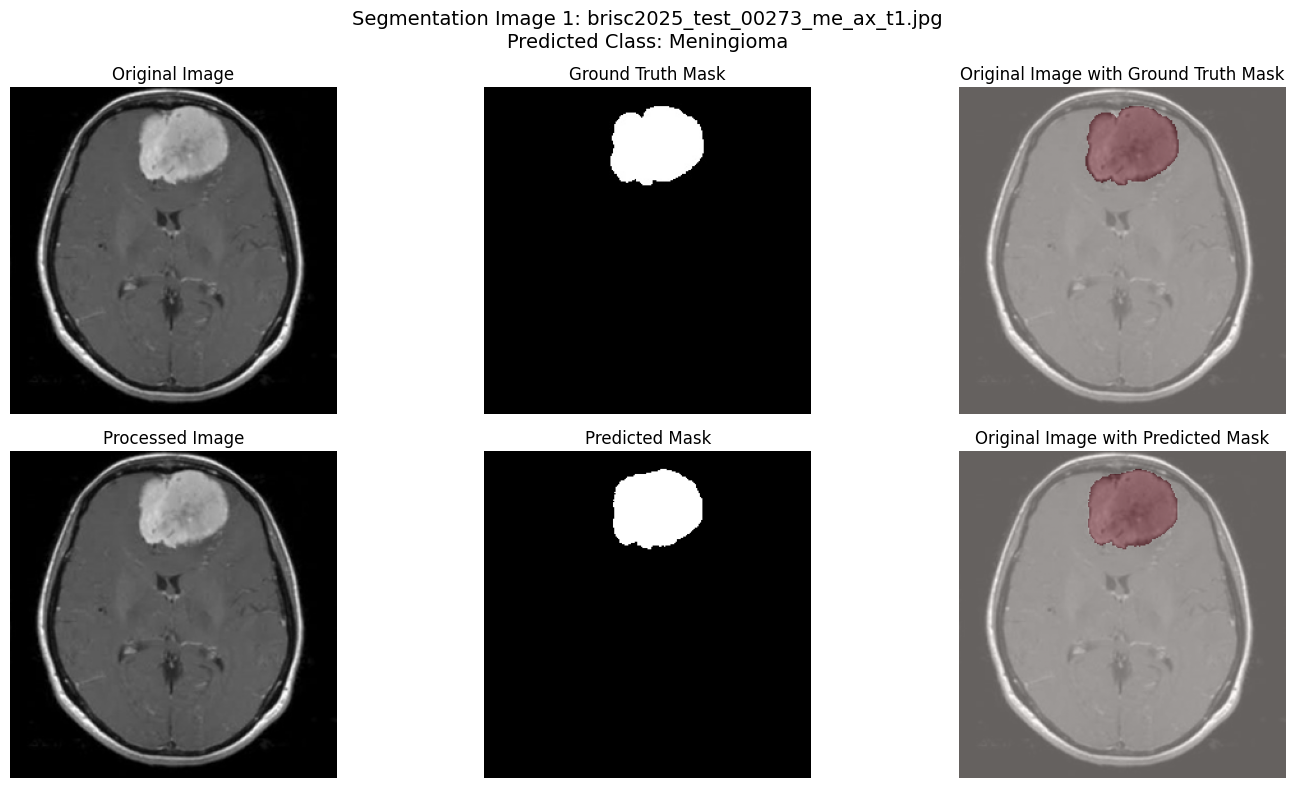

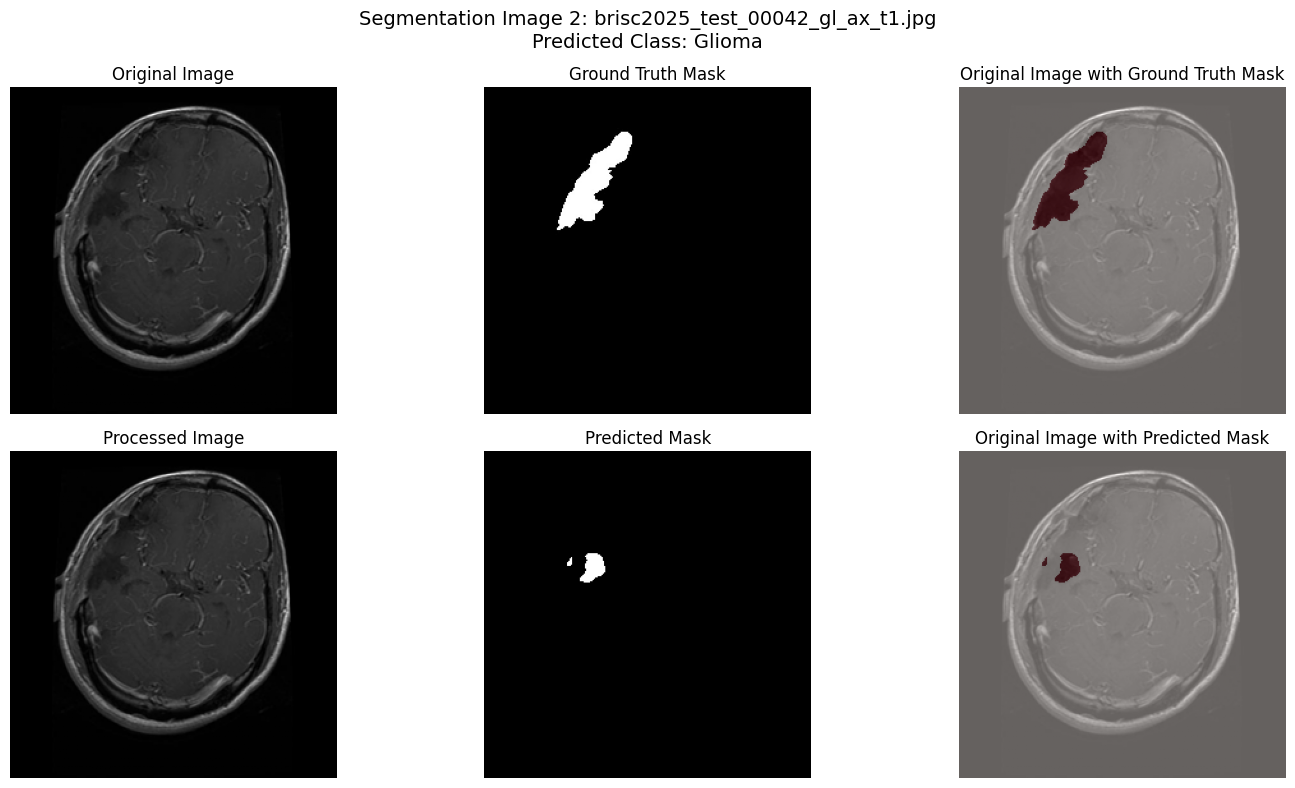

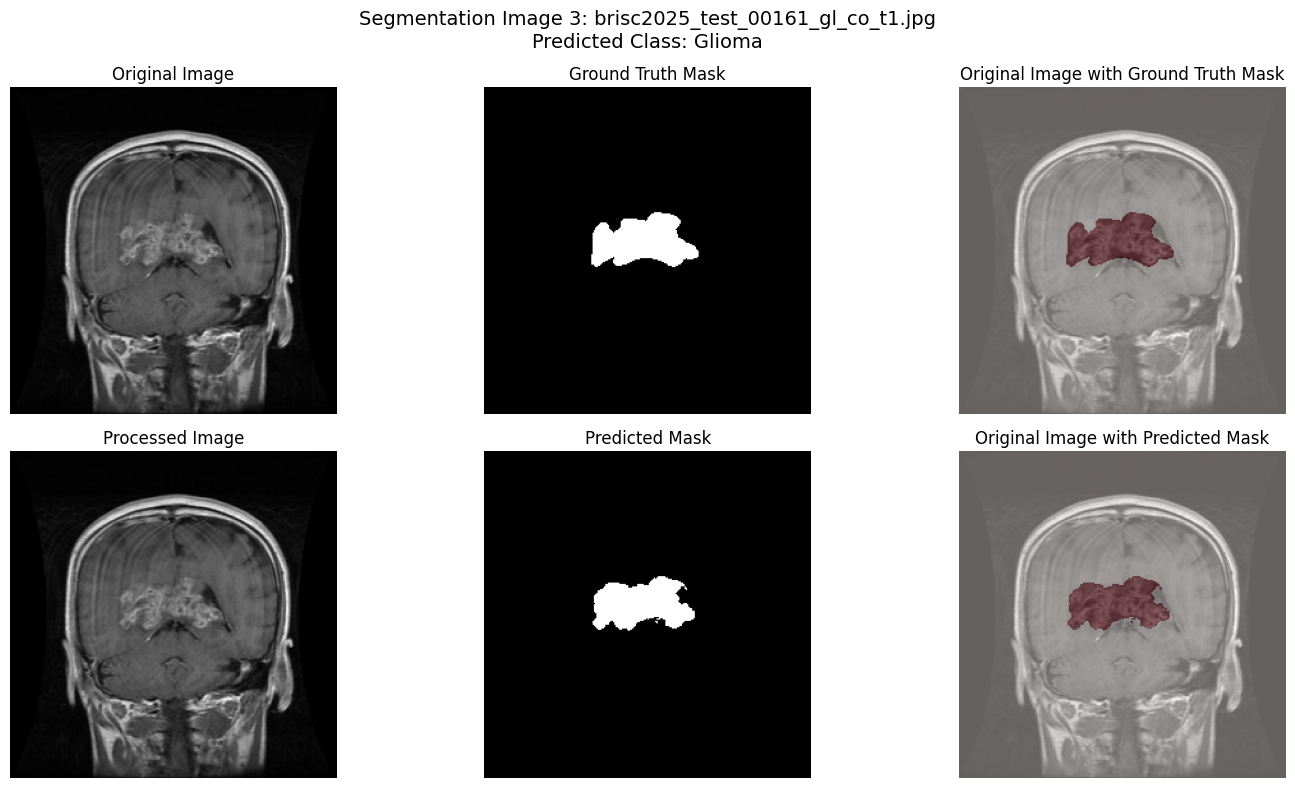

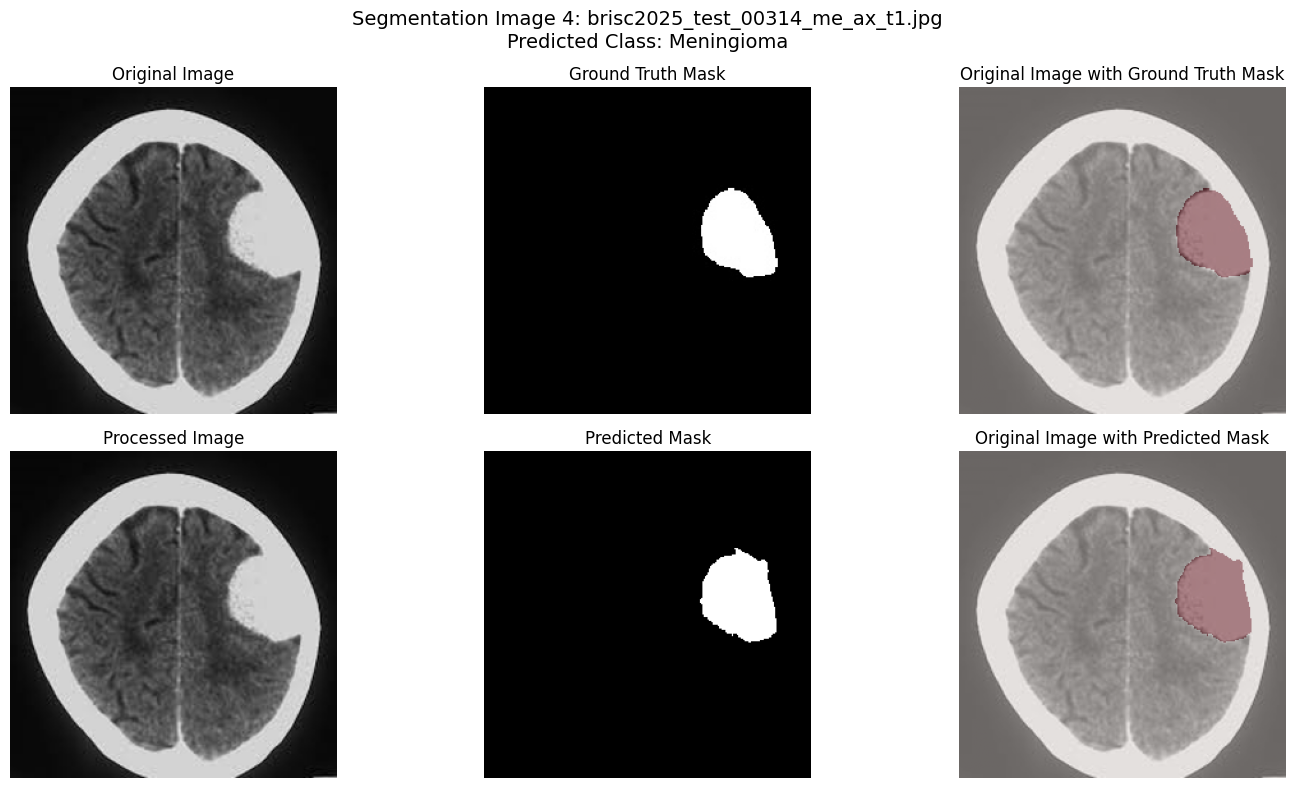

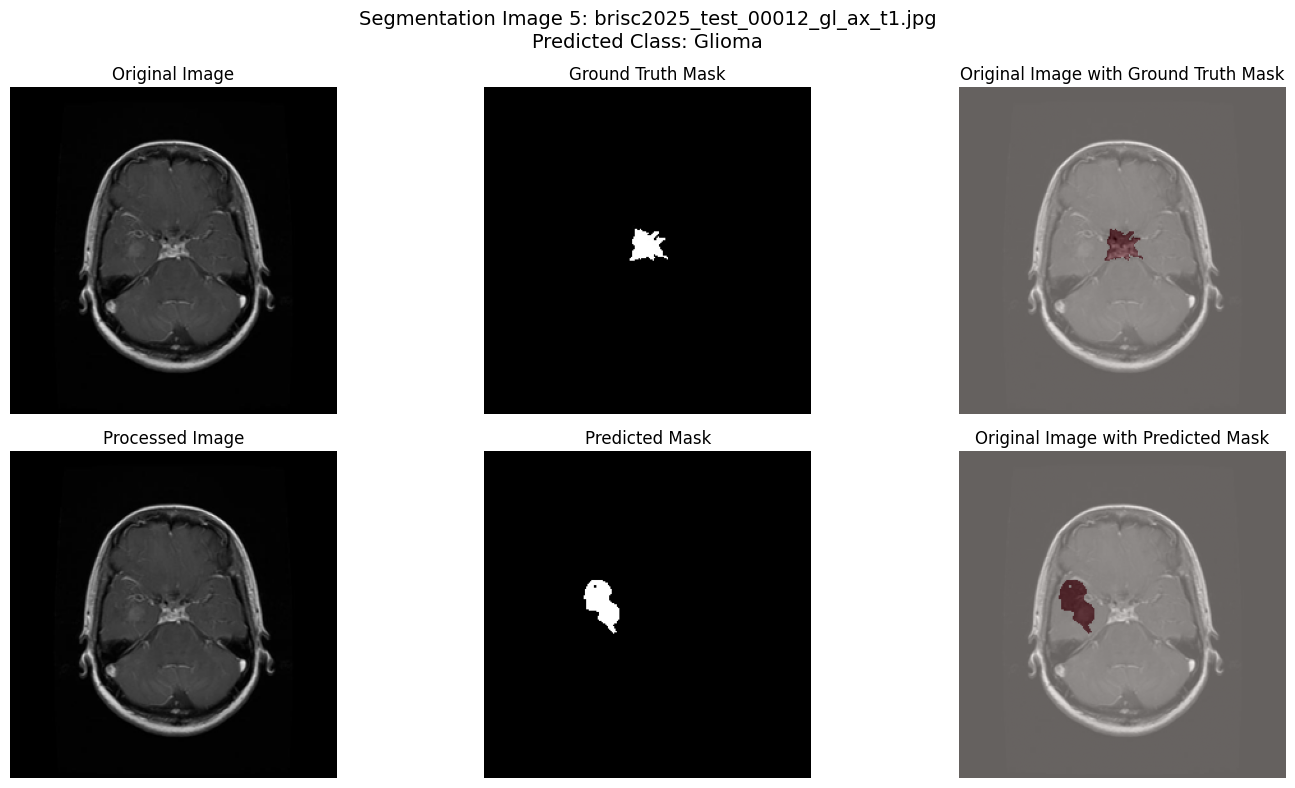


Classification Test Images:


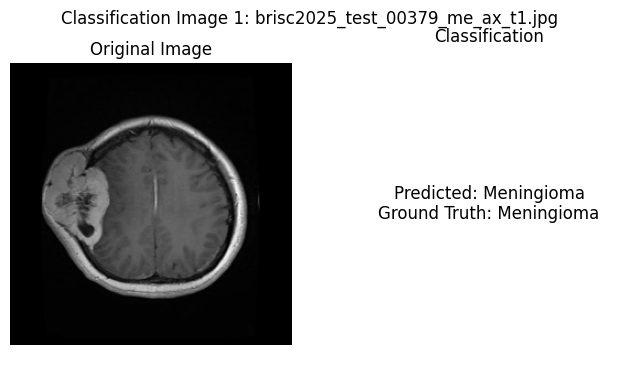

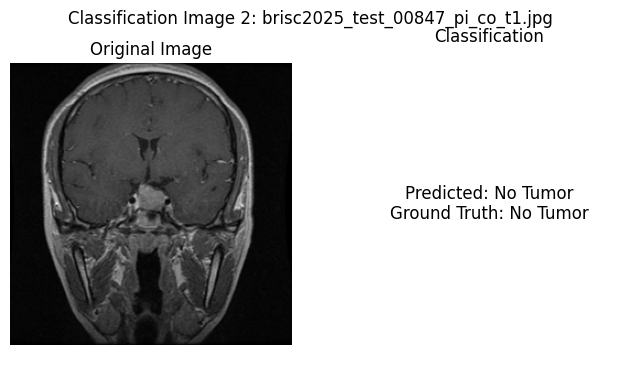

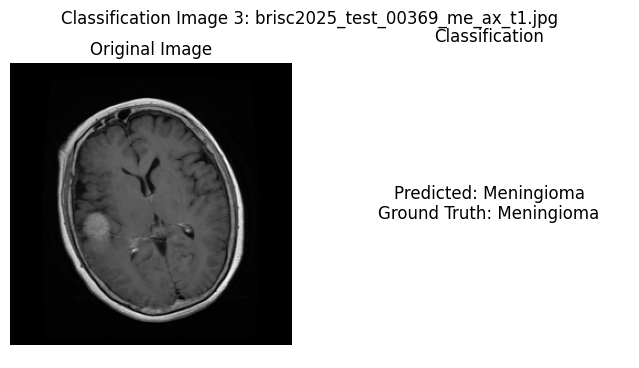

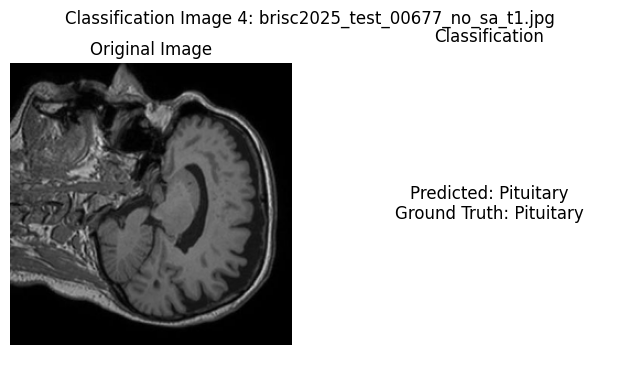

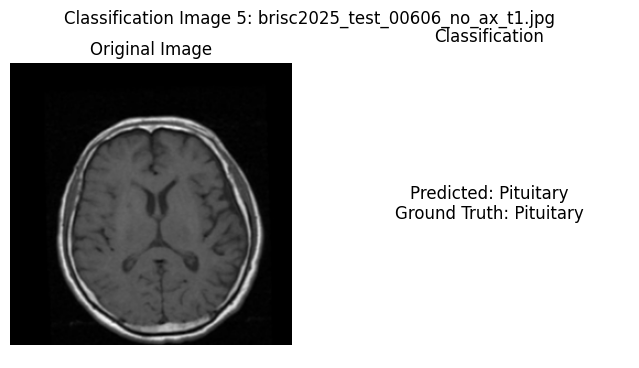


Evaluating Attention U-Net Model:


Evaluating Segmentation: 100%|██████████| 54/54 [00:20<00:00,  2.60it/s]



Segmentation Metrics:
Test BCE Loss - 0.030906 | Test Dice Loss - 0.154960 | Test IoU - 0.731390


Evaluating Classification: 100%|██████████| 63/63 [00:09<00:00,  6.80it/s]



Classification Metrics:
Test Loss: 0.1006, Test Accuracy: 0.9730
Precision: 0.9731, Recall: 0.9730, F1-Score: 0.9729

Per-Class Classification Metrics:
Class 0 (Glioma): Precision=0.9878, Recall=0.9528, F1-Score=0.9699
Class 1 (Meningioma): Precision=0.9575, Recall=0.9575, F1-Score=0.9575
Class 2 (Pituitary): Precision=0.9790, Recall=1.0000, F1-Score=0.9894
Class 3 (No Tumor): Precision=0.9739, Recall=0.9933, F1-Score=0.9835

Segmentation Test Images:


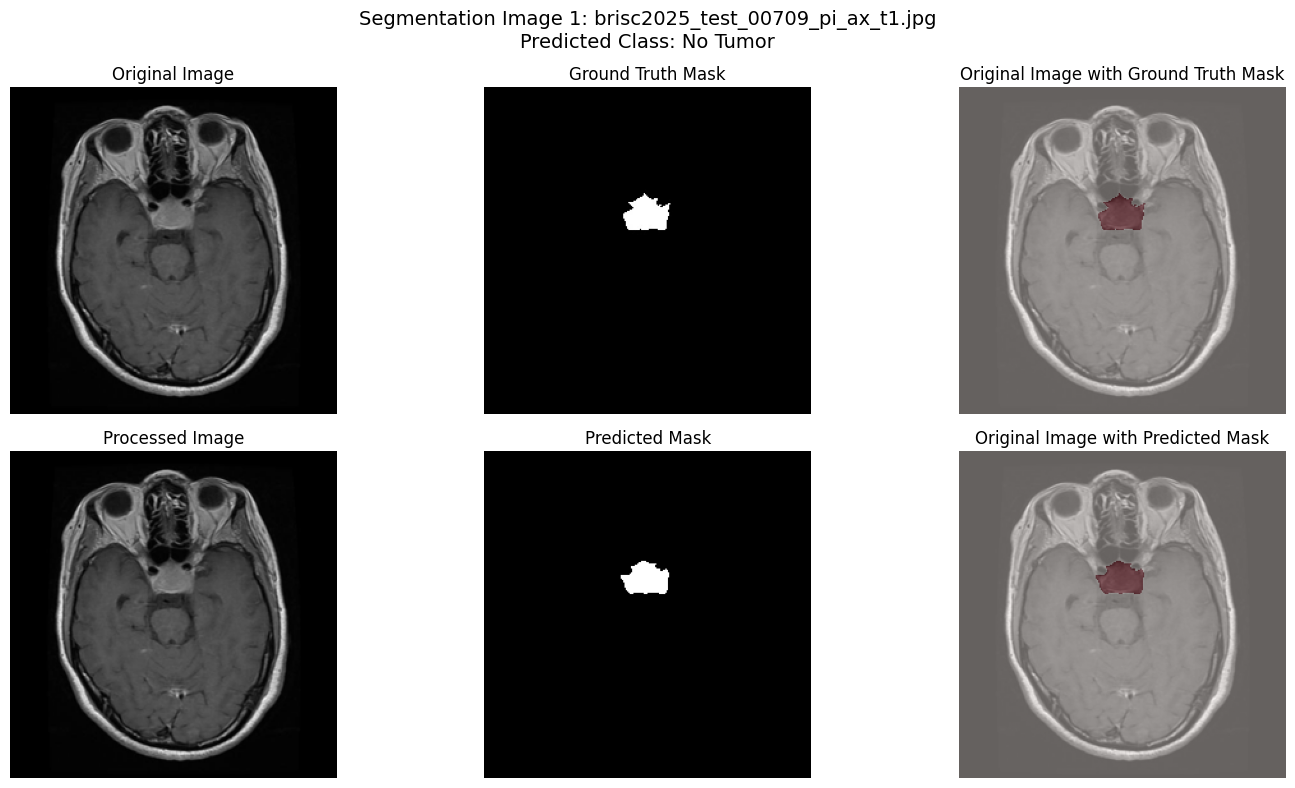

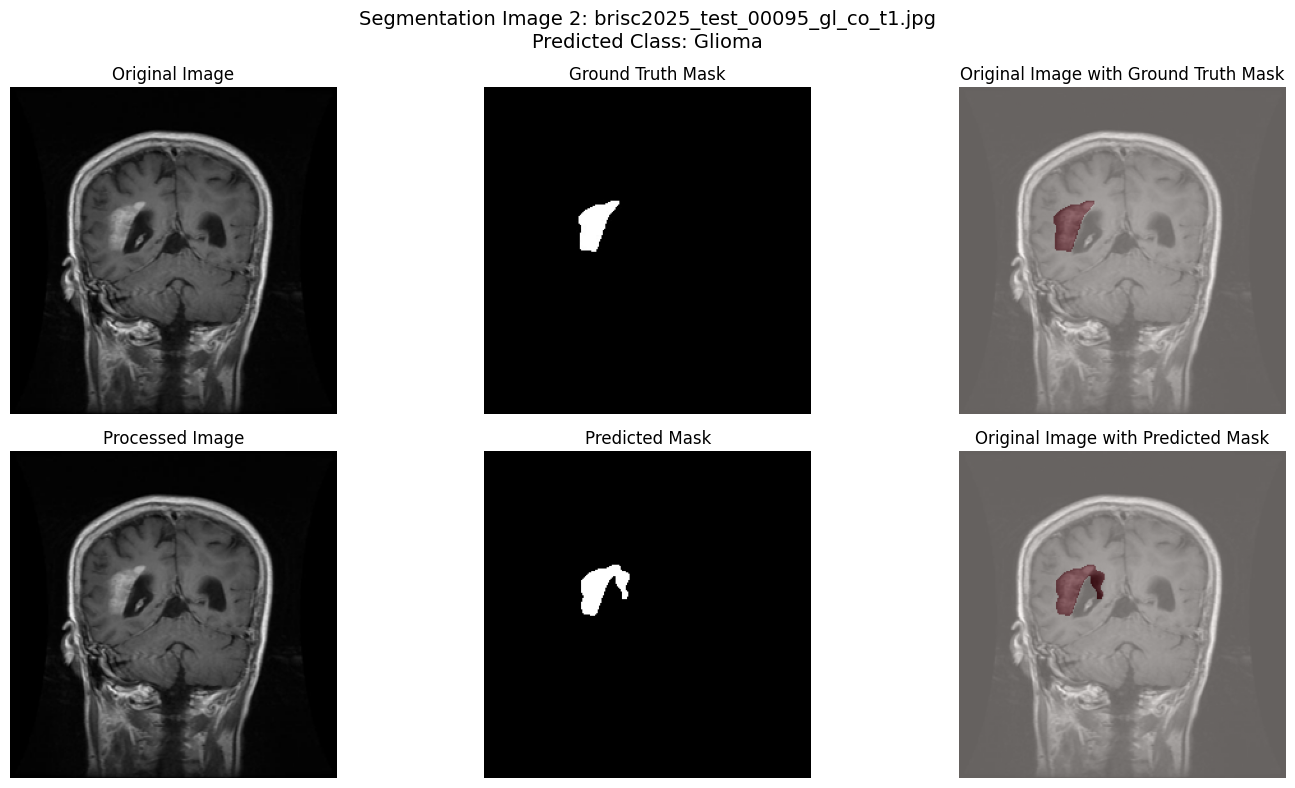

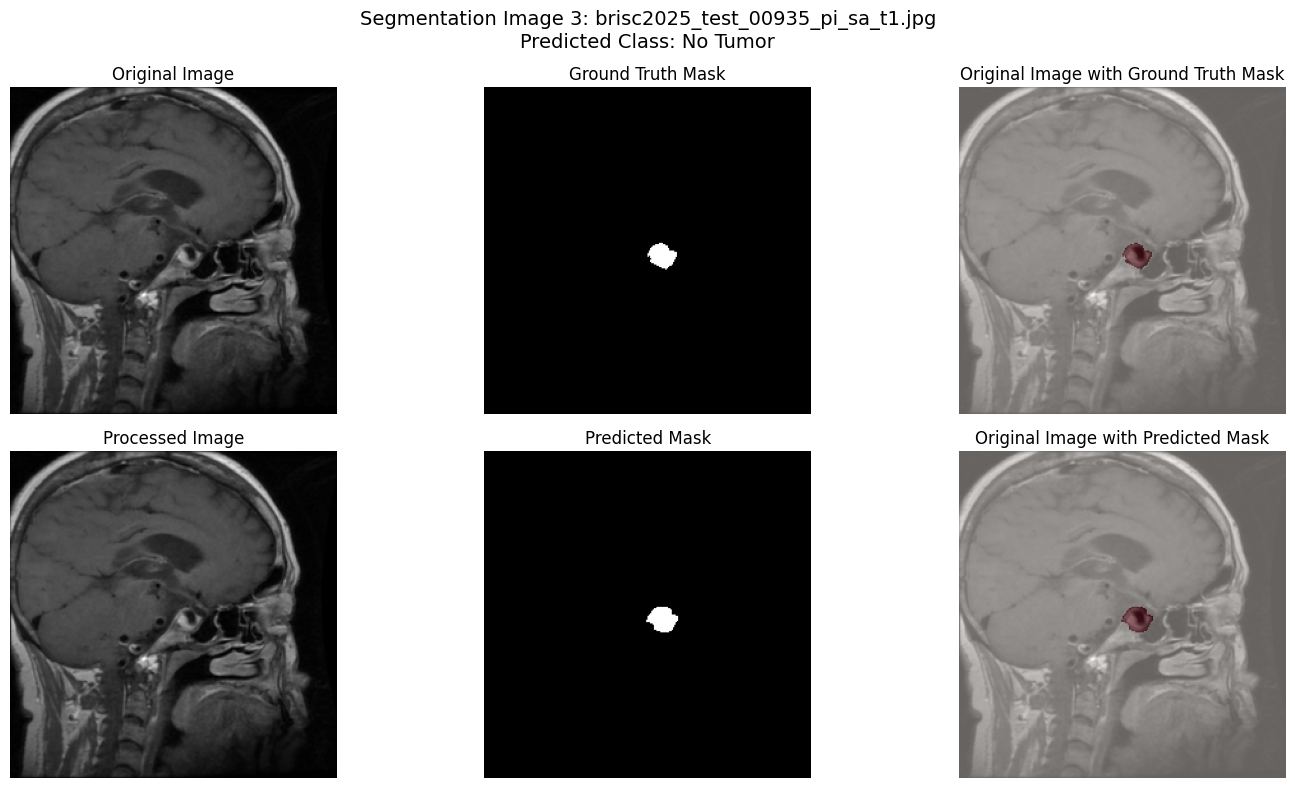

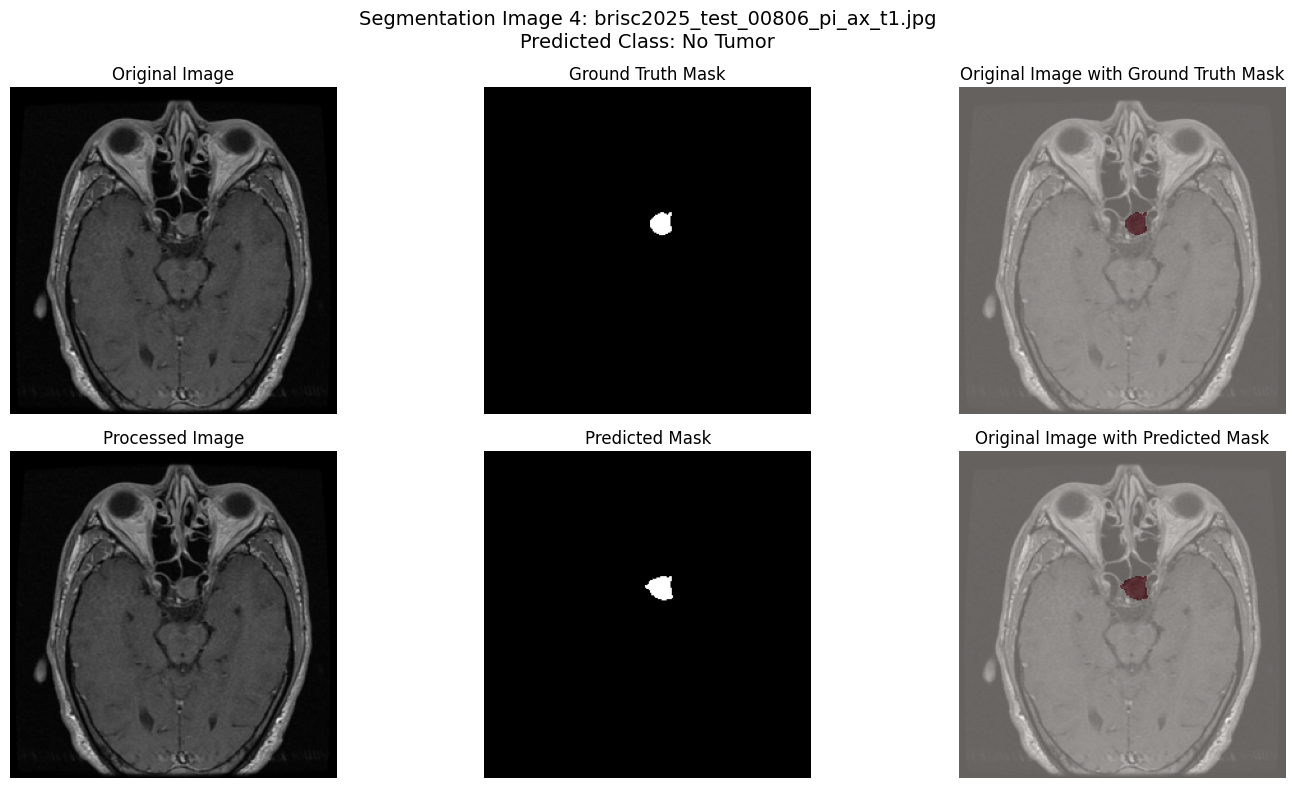

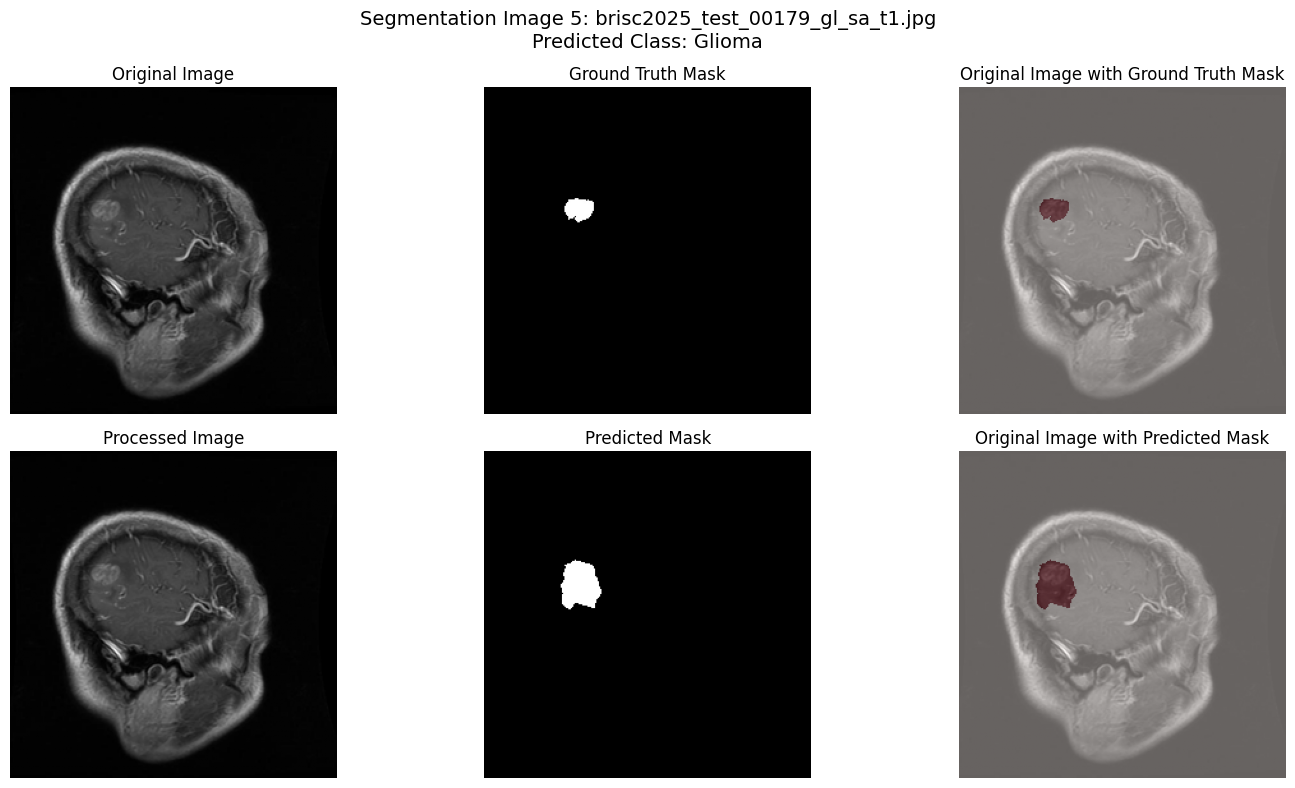


Classification Test Images:


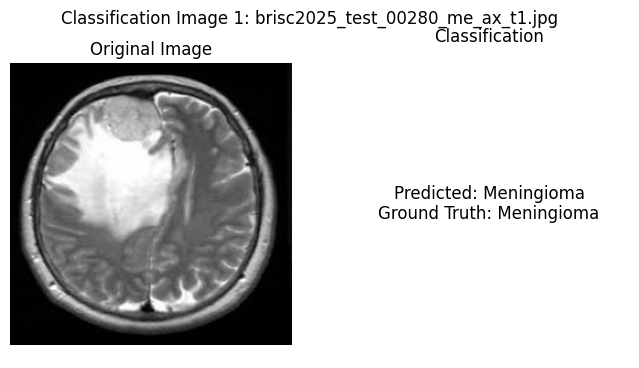

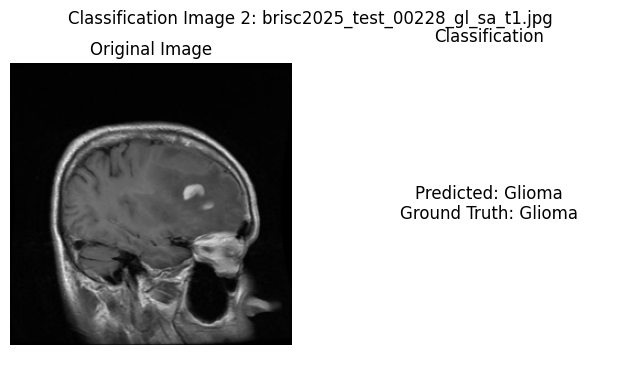

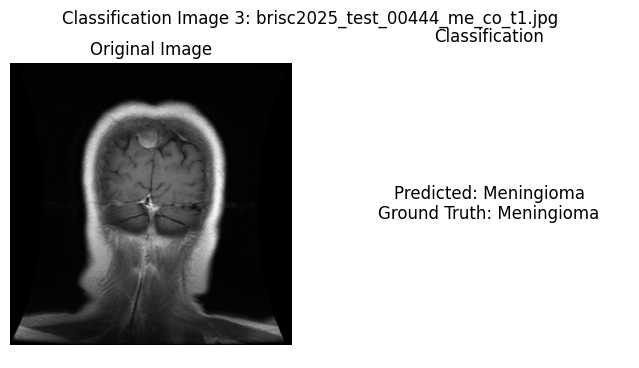

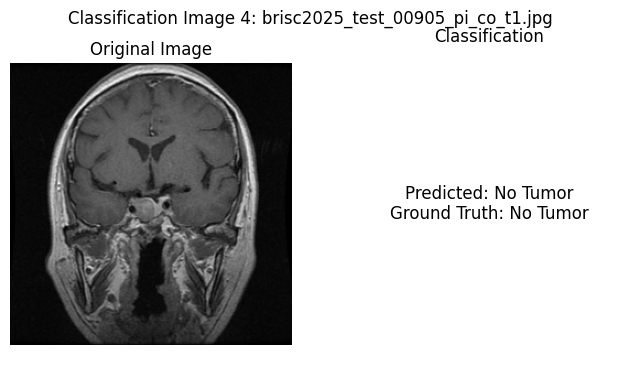

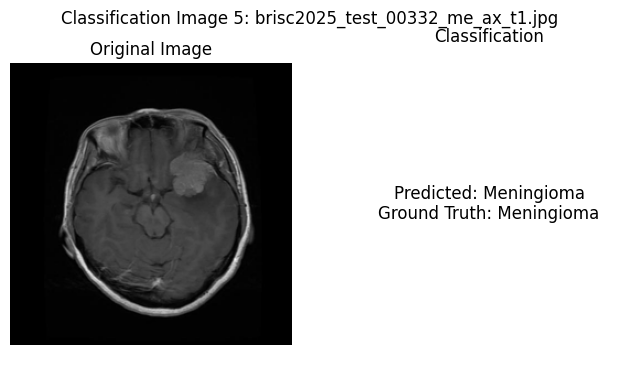

In [ ]:
# Evaluate and display predictions
def evaluate_predictions(model_seg, model_cls, seg_test_loader, cls_test_loader, cls_dataset, max_images=5):
    dice_loss = DiceLoss()
    bce_loss = nn.BCEWithLogitsLoss()
    loss_cls = nn.CrossEntropyLoss()

    # Evaluate segmentation
    model_seg.eval()
    seg_bce, seg_dice, seg_iou = 0.0, 0.0, 0.0
    with torch.no_grad():
        for x, y in tqdm(seg_test_loader, desc="Evaluating Segmentation"):
            if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
                print("NaN/Inf detected in segmentation test input or mask")
                continue
            y_pred = model_seg(x)
            seg_bce += bce_loss(y_pred, y).item()
            seg_dice += dice_loss(y_pred, y).item()
            seg_iou += calculate_iou(y_pred, y).item()

    avg_seg_bce = seg_bce / len(seg_test_loader)
    avg_seg_dice = seg_dice / len(seg_test_loader)
    avg_seg_iou = seg_iou / len(seg_test_loader)

    print("\nSegmentation Metrics:")
    print(f"Test BCE Loss - {avg_seg_bce:.6f} | Test Dice Loss - {avg_seg_dice:.6f} | Test IoU - {avg_seg_iou:.6f}")

    # Evaluate classification
    model_cls.eval()
    cls_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in tqdm(cls_test_loader, desc="Evaluating Classification"):
            if torch.isnan(x).any() or torch.isinf(x).any() or torch.isnan(y).any() or torch.isinf(y).any():
                print("NaN/Inf detected in classification test input or label")
                continue
            y_pred = model_cls(x)
            cls_loss += loss_cls(y_pred, y).item()
            preds = y_pred.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_cls_loss = cls_loss / len(cls_test_loader)
    cls_accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\nClassification Metrics:")
    print(f"Test Loss: {avg_cls_loss:.4f}, Test Accuracy: {cls_accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print("\nPer-Class Classification Metrics:")
    per_class_metrics = precision_recall_fscore_support(all_labels, all_preds, labels=[0, 1, 2, 3], zero_division=0)
    for i in range(4):
        print(f"Class {i} ({tumor_names[i]}): Precision={per_class_metrics[0][i]:.4f}, Recall={per_class_metrics[1][i]:.4f}, F1-Score={per_class_metrics[2][i]:.4f}")

    # Prepare test image and mask paths
    seg_test_images = [os.path.join(seg_test_img, f) for f in os.listdir(seg_test_img) if f.endswith('.jpg')]
    seg_test_masks = [os.path.join(seg_test_mask, f.replace('.jpg', '.png')) for f in seg_test_images]
    cls_test_images = []
    for class_dir in sorted(os.listdir(cls_test_dir)):
        class_path = os.path.join(cls_test_dir, class_dir)
        cls_test_images.extend([os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.jpg')])

    random.shuffle(seg_test_images)
    random.shuffle(cls_test_images)

    # Display predictions
    display_seg_cls_predictions(seg_test_images, seg_test_masks, cls_test_images, model_seg, model_cls, cls_dataset, max_images=max_images)

# Load models and evaluate
model_unet.load_state_dict(torch.load('model_unet.pth'))
model_cls.load_state_dict(torch.load('model_cls.pth'))
model_att_unet.load_state_dict(torch.load('model_att_unet.pth'))

print("\nEvaluating U-Net Model:")
evaluate_predictions(model_unet, model_cls, seg_test_loader, cls_test_loader, cls_test_dataset, max_images=5)

print("\nEvaluating Attention U-Net Model:")
evaluate_predictions(model_att_unet, model_cls, seg_test_loader, cls_test_loader, cls_test_dataset, max_images=5)